In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from joblib import Parallel, delayed

import h5py
import os

In [2]:
class HDF5ImageDiffDataset(Dataset):
    def __init__(self, hdf5_file):
        self.hdf5_file = hdf5_file
        with h5py.File(self.hdf5_file, 'r') as file:
            self.length = file['images'].shape[0]

    def __len__(self):
        return self.length

    def __getitem__(self, idx):
        with h5py.File(self.hdf5_file, 'r') as file:
            image = file['images'][idx]
            diff = file['diffs'][idx]
        return image, diff

In [3]:
class MultiKernelConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_sizes=[3, 5, 7]):
        super(MultiKernelConv2d, self).__init__()
        self.branches = nn.ModuleList()
        for kernel_size in kernel_sizes:
            branch = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size, padding=kernel_size // 2),
                nn.BatchNorm2d(out_channels),
                nn.ReLU()
            )
            self.branches.append(branch)

    def forward(self, x):
        outputs = []
        for branch in self.branches:
            outputs.append(branch(x))
        return torch.cat(outputs, 1)

class CNN(nn.Module):
    def __init__(self, n_classes, img_size):
        super(CNN, self).__init__()
        self.conv = MultiKernelConv2d(1, 3)
        self.fc1 = nn.Linear(3 * 3 * (img_size) * (img_size), 2048)
        self.fc2 = nn.Linear(2048, n_classes)

    def forward(self, x):
        x = self.conv(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

class ApplyMask(nn.Module):
    def __init__(self):
        super(ApplyMask, self).__init__()

    def forward(self, logits, x):
        neighbors = torch.roll(x, shifts=1, dims=2) + \
                    torch.roll(x, shifts=-1, dims=2) + \
                    torch.roll(x, shifts=1, dims=3) + \
                    torch.roll(x, shifts=-1, dims=3)
        mask = ((neighbors > 0) & (x == 0)).reshape(logits.shape)
        masked_logits = torch.where(mask, logits, torch.tensor(-1e9))
        return masked_logits

class CNNWithMask(nn.Module):
    def __init__(self, n_channels, n_classes):
        super(CNNWithMask, self).__init__()
        self.unet = CNN(n_channels, n_classes)
        self.apply_mask = ApplyMask()

    def forward(self, x):
        logits = self.unet(x)
        logits = self.apply_mask(logits, x)
        return logits

In [4]:
dataset = HDF5ImageDiffDataset('../data/images_diffs.hdf5')
data_loader = DataLoader(dataset, batch_size=100, shuffle=True)

model = CNNWithMask(150*150, 150)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.train()

idx = 0
for images, diffs in data_loader:
    images = images.to(device)
    diffs = diffs.to(device)
    optimizer.zero_grad()
    outputs = model(images)
    loss = criterion(outputs, diffs)
    loss.backward()
    optimizer.step()
    print(loss.item())
    idx += 1
    if idx > 100:
        break


OutOfMemoryError: CUDA out of memory. Tried to allocate 792.00 MiB. GPU 0 has a total capacity of 1.83 GiB of which 444.94 MiB is free. Including non-PyTorch memory, this process has 1.38 GiB memory in use. Of the allocated memory 1.29 GiB is allocated by PyTorch, and 4.25 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

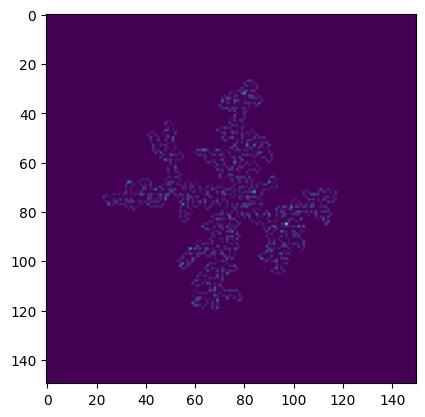

In [ ]:
model.eval()
X  = pd.read_parquet('../data/size150_aggregations1000_f27ba062-311b-425f-b701-20b6bb033534.parquet').to_numpy()[-1]
X = X.reshape(1, 1, 150, 150)
X = torch.tensor(X, dtype=torch.float32).to(device)
output = F.softmax(model(X), dim=1)
output = output.detach().cpu().numpy()
plt.imshow(output[0].reshape(150, 150));

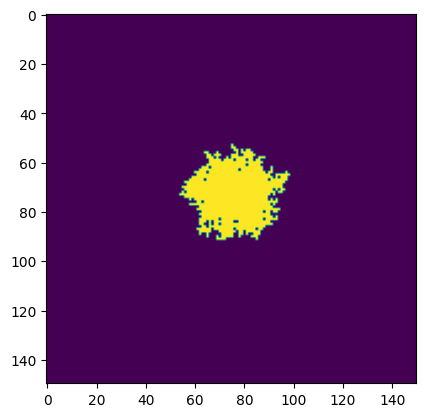

In [ ]:
n = 150
grid = np.zeros((1, 1, n,n))
grid[0, 0, n//2, n//2] = 1

for i in range(1000):
    input = torch.tensor(grid, dtype=torch.float32).to(device)
    output = model(input)
    output = F.softmax(output, dim=1)
    output = output.detach().cpu().numpy()
    idx = np.random.choice(n*n, p=output[0].reshape(n*n))
    grid[0, 0, idx // n, idx % n] = 1

plt.imshow(grid[0, 0]);